<a href="https://www.kaggle.com/code/mohammadtalaat7/titanic-huge-dataset-with-86-53-f1-score?scriptVersionId=225890845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import PrettyPrinter
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import warnings
import os

pp = PrettyPrinter(indent=2)
warnings.simplefilter(action="ignore")

In [2]:
def wrangle(
    filepath:str
) -> pd.DataFrame:
    """
    Reads a CSV file, cleans it, and return it.

    Parameters:
    ----------
    path : str
        The path that contains our CSV file that contains the data needed to process.

    Returns:
    -------
    pd.DataFrame
        A DataFrame contains cleaned data and ready to use.
    """

    # Read CSV file
    df = pd.read_csv(filepath, index_col = "PassengerId")

    # Drop non-important features
    df.drop(columns = ["Name", "Cabin", "Ticket", "SibSp"], inplace = True)

    # Converting Categorical Features
    df["Sex"] = (df["Sex"] == "male").astype(int)

    # Converting Float Features
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["Age"] = np.ceil(df["Age"]).astype(int)

    # Remove NaN values in Embarked Feature
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

    # Make sure that there is no NaN in our data
    df.dropna(inplace = True)
    
    return df

In [3]:
df = wrangle("/kaggle/input/titanic-huge-dataset-1m-passengers/huge_1M_titanic.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 1310 to 1001309
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Survived  1000000 non-null  int64  
 1   Pclass    1000000 non-null  int64  
 2   Sex       1000000 non-null  int64  
 3   Age       1000000 non-null  int64  
 4   Parch     1000000 non-null  int64  
 5   Fare      1000000 non-null  float64
 6   Embarked  1000000 non-null  object 
dtypes: float64(1), int64(5), object(1)
memory usage: 61.0+ MB


In [4]:
target = "Survived"
X = df.drop(columns=target)
y = df[target]

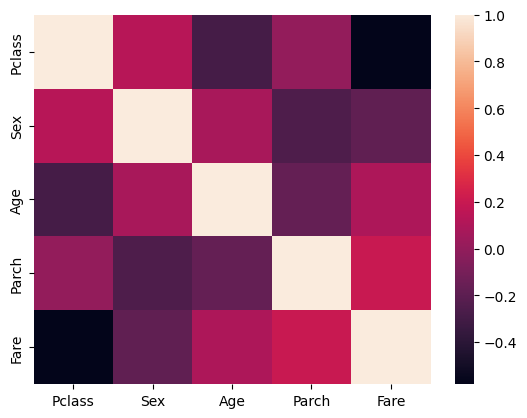

In [5]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns=target).corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation);

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = .2, random_state = 42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size = .2, random_state = 42
)

In [7]:
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.62


In [8]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Define preprocessing: Only OneHotEncode categorical features, keep others as is
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_cols) #handle_unknown="ignore"
    ],
    remainder="passthrough"  # Leaves numerical features unchanged
)

In [9]:
depth_hyperparams = range(1, 26, 2)

# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        preprocessor,
        DecisionTreeClassifier(
        min_samples_split = 8,
        min_samples_leaf = 2,
        max_features = None,
        max_depth = d,
        random_state = 42)
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.7888921875, 0.816215625, 0.828715625]
Validation Accuracy Scores: [0.78974375, 0.81766875, 0.82955625]


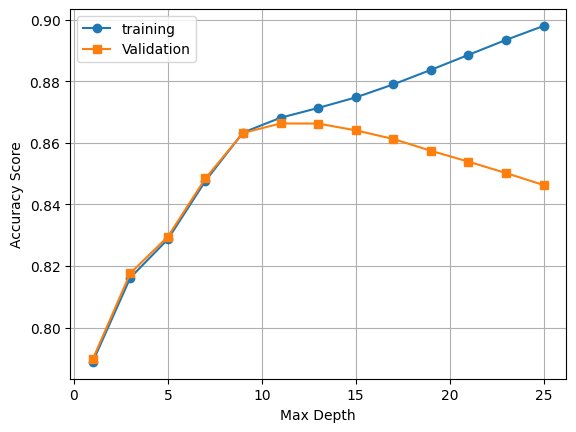

In [10]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, marker='o', label = "training")
plt.plot(depth_hyperparams, validation_acc, marker='s', label = "Validation")
# plt.xticks(depth_hyperparams)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.grid(True)
plt.legend();

In [11]:
f1_scorer = make_scorer(f1_score, average='weighted')

testmodel = make_pipeline(
    preprocessor,
    DecisionTreeClassifier()
)

param_distributions = {
    'decisiontreeclassifier__criterion': ["gini", "entropy", "log_loss"],
    'decisiontreeclassifier__max_depth': range(1, 26, 2),
    'decisiontreeclassifier__min_samples_split': [2, 4, 6, 8],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 3, 4],
    'decisiontreeclassifier__max_features': [None, "log2", "sqrt"],
    }

random_search = RandomizedSearchCV(
    estimator = testmodel,
    param_distributions=param_distributions,
    n_iter=25,
    scoring = f1_scorer,
    cv=5,
    n_jobs=-1,
    random_state=42,
    return_train_score=True  # Enables tracking train scores
)
random_search.fit(X_train, y_train)

# Extract best parameters
best_params = random_search.best_params_

# Get training and validation scores
train_score = random_search.cv_results_["mean_train_score"][random_search.best_index_]
val_score = random_search.cv_results_["mean_test_score"][random_search.best_index_]


# Check for overfitting
if train_score - val_score > 0.05:  # Overfitting threshold
    print("Warning: Potential overfitting detected!")
    print(f"Training Score: {train_score:.4f} | Validation Score: {val_score:.4f}")
    
    # Adjust hyperparameters to reduce overfitting
    if 'decisiontreeclassifier__max_depth' in best_params:
        best_params['decisiontreeclassifier__max_depth'] = max(3, best_params['decisiontreeclassifier__max_depth'] - 5)
    if 'decisiontreeclassifier__min_samples_leaf' in best_params:
        best_params['decisiontreeclassifier__min_samples_leaf'] = min(4, best_params['decisiontreeclassifier__min_samples_leaf'] + 1)
    if 'decisiontreeclassifier__min_samples_split' in best_params:
        best_params['decisiontreeclassifier__min_samples_split'] = min(8, best_params['decisiontreeclassifier__min_samples_split'] + 2)

    print(f"🔧 Adjusted Hyperparameters: {best_params}")

# Print final results
print(f'Best Parameters: {best_params}')
print(f'Best Validation Score: {val_score:.4f}')

Best Parameters: {'decisiontreeclassifier__min_samples_split': 8, 'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_depth': 11, 'decisiontreeclassifier__criterion': 'gini'}
Best Validation Score: 0.8634


In [12]:
model = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(
        min_samples_split = 8,
        min_samples_leaf = 2,
        max_features = None,
        max_depth = 11,
        random_state = 42)
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Embarked'], dtype='object'))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=11, min_samples_leaf=2,
                                        min_samples_split=8,
                                        random_state=42))])

In [13]:
model.named_steps["decisiontreeclassifier"].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 11,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [14]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = accuracy_score(y_val, model.predict(X_val))
report = classification_report(y_val, model.predict(X_val), output_dict=True)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.87
Validation Accuracy: 0.87


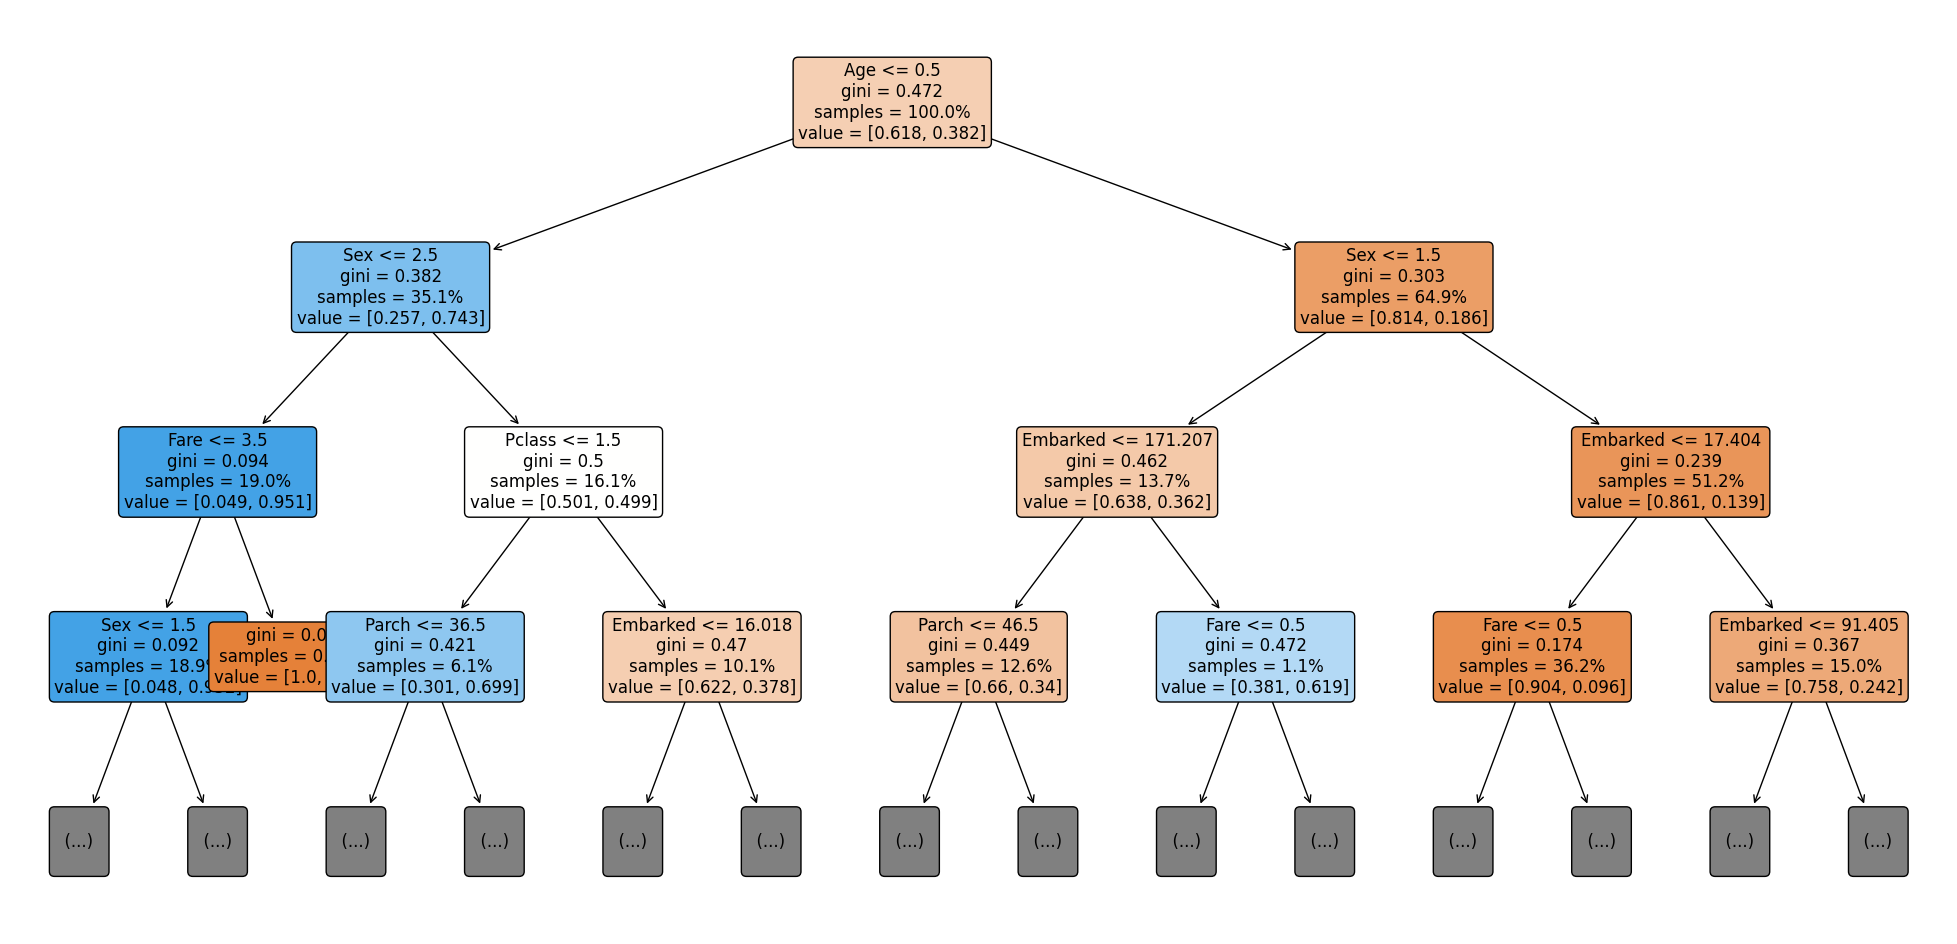

In [15]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns.to_list(),
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [16]:
report_test = classification_report(y_test, model.predict(X_test), output_dict=True)

print("Testing Report: \n")
pp.pprint(report_test)

Testing Report: 

{ '0': { 'f1-score': 0.8951132300357567,
         'precision': 0.8646669726910834,
         'recall': 0.9277818598754916,
         'support': 123847},
  '1': { 'f1-score': 0.8120419359792275,
         'precision': 0.8667322277353121,
         'recall': 0.763843840689139,
         'support': 76153},
  'accuracy': 0.86536,
  'macro avg': { 'f1-score': 0.8535775830074921,
                 'precision': 0.8656996002131978,
                 'recall': 0.8458128502823152,
                 'support': 200000},
  'weighted avg': { 'f1-score': 0.8634825887543224,
                    'precision': 0.8654533495279992,
                    'recall': 0.86536,
                    'support': 200000}}
